In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("reductions.ipynb")

In [2]:
!pip install -r requirements.txt --quiet
import otter
grader = otter.Notebook("reductions.ipynb")
assert otter.__version__ >= "4.2.0", "Please restart your kernel."

In [3]:
!pip install otter-grader --upgrade --quie

In [4]:
import itertools
import tqdm
import time
import random
import math
import pickle
import matplotlib.pyplot as plt
import pulp

In [5]:
# load testing data
with open('data.pkl', 'rb') as f:
    U_test, S_test, ans_test = pickle.load(f)['testing']

## Reductions
In class, we've seen that we can *reduce* one problem to another, by converting an instance of problem $A$ to an instance of problem $B$. We've seen that this allows us to prove that $B$ is at least as hard as $A$, but this also allows us to use an efficient black-box solver for problem $B$ to solve problem $A$. 

Namely, there exist many solver packages for Integer Linear Programming (CPLEX, Gurobi) and SAT (Glucose, Maplesat, Z3) which have been highly optimized over the course of several decades. Although these solvers take exponential time since ILP and SAT are NP-complete, good solver packages use advanced algorithms and are highly optimized, meaning they are very fast on reasonably-sized inputs. Rather than implement a solver from scratch, it may be more efficient to reduce a problem to integer LP or SAT in polynomial time and then call an existing solver library. 

In this notebook, we'll see how to solve the optimization variant of Set Cover by reducing it to integer LP and calling a black-box ILP solver. 

## 1) Naive Set Cover
We've seen how to approximate Set Cover using a greedy algorithm, this approximation may not always be exact. What if we want an exact answer? Since Set Cover is NP-hard, we can't do much better than brute force unless P=NP. Below, implement a brute force solver for the Set Cover optimization problem. 

More formally, implement a brute force algorithm for the following:

Given $U$, a list of elements, and $S$, is a list of sets, find the minimal set cover of $U$ using $S$; that is, the combination of sets from $S$ which covers all elements in $U$ using as few sets as possible. Your answer should be a list of indices, where each index corresponds to a set in $S$ which is part of your set cover. Indices can be returned in any order. If no set cover is possible, return the empty list.

For simplicity, you can assume that all elements in $U$ are integers.

Hint: `itertools.combinations` may be useful here.

In [6]:
U = [1,3,5]
S = [{1,2},{3,4},{5,6}]
S_key = [0,1,2,]
for size in range(1, len(S)+1):
    #S_key_test = itertools.combinations(S_key, size)
    for subset in itertools.combinations(range(len(S)), size):
        print('subset: ')
        print(subset)
        covered = set().union(*[S[key] for key in subset])
        print('covered: ')
        print(covered)
        for u in U:
            if u not in covered:
                break
        print('keys: ')
        print(list(subset))

subset: 
(0,)
covered: 
{1, 2}
keys: 
[0]
subset: 
(1,)
covered: 
{3, 4}
keys: 
[1]
subset: 
(2,)
covered: 
{5, 6}
keys: 
[2]
subset: 
(0, 1)
covered: 
{1, 2, 3, 4}
keys: 
[0, 1]
subset: 
(0, 2)
covered: 
{1, 2, 5, 6}
keys: 
[0, 2]
subset: 
(1, 2)
covered: 
{3, 4, 5, 6}
keys: 
[1, 2]
subset: 
(0, 1, 2)
covered: 
{1, 2, 3, 4, 5, 6}
keys: 
[0, 1, 2]


In [7]:
def set_cover_naive(U, S):
    '''
    Brute-force impmenentation of the Set Cover optimization problem. 

    args:
        - U:List[int] is a list of all of the elements that we wish to cover.
        - S:List[Set[int]] is a list of sets; each set S[i] is a Python set of all of the items 
        that S[i] covers.
    returns:
        - List[int] depicting the minimal set cover of U. Each element in the 
            resulting list should be the index of a set in S. If there is no feasible cover, 
            return an empty list.
    '''
    #print('U: ', U)
    #print("S: ", S)
    for size in range(1, len(S)+1):
        for subset in itertools.combinations(range(len(S)), size):
            #print('subset: ')
            #print(subset)
            covered = set().union(*[S[key] for key in subset])
            #print('covered: ')
            #print(covered)
            if set(U).issubset(covered):
                #print(list(subset))
                return list(subset)
            else:
                continue
    return []

To help you debug, we've given you some sample test cases and answers to test your implementation.

Our tests are not comprehensive: we also encourage you to add your own test cases to test specific edge cases that might cause your code to fail.

In [8]:
for U, S, ans in tqdm.tqdm(zip(U_test, S_test, ans_test)):
    your_sol = set_cover_naive(U, S)

    if len(your_sol) > 0:
        assert ans > 0, 'Your solution says a feasible cover exists even though no such cover exists'

        your_cover = set([j for i in your_sol for j in S[i]])
        assert set(U).issubset(your_cover), 'Your solution does not cover all elements!'
    else:
        assert ans == 0, 'Your solution says no feasible cover exists even though a solution exists'

    assert len(your_sol) == ans, f'Optimal solution has length {ans} but yours has length {len(your_sol)}'

25it [00:04,  5.54it/s]


In [9]:
grader.check("q1")

100%|██████████| 120/120 [00:18<00:00,  6.32it/s]


q1 results: All test cases passed!

## 2) Black-box ILP Solver

<b> For this part, you don't have to submit anything. If you're already comfortable with mathematical modeling and using PuLP, feel free to skip to Q3.</b>

By using a pre-made ILP solver library, much of the hard work is already done for us. We can assume that the solver gives correct results, and that the solver is pretty fast (as far as algorithms for NP-complete problems go).  

For this assignment, we'll use PuLP, which is a Python wrapper for various LP and integer LP solvers. In general, we'll treat the solver like a black box -- besides the Simplex algorithm we saw in class, you don't need to know any other LP solver algorithms or understand how PuLP works internally. In this question, we'll walk through the basics of formulating and solving integer LPs with PuLP.

As an example, let's say we want to solve the following integer LP:
$$\min_x \quad 3 x_0 + 4 x_1 + 6 x_2$$
<center> such that </center>

$$x_0 + 2 x_1 \ge 5$$
$$|x_1 - x_2| \le 2$$
$$x_0, x_1, x_2 \in \mathbb{N}$$

First, we initialize a `pulp.LpProblem`. The constructor takes 2 arguments: 
1. The name of the problem (can be anything)
2. An optimization direction (either `pulp.LpMinimize` or `pulp.LpMaximize`). 

In [10]:
problem = pulp.LpProblem('example_1', pulp.LpMinimize)

Next, we define our *optimization variables*. The variable constructor takes in a name parameter, followed by a few keyword arguments. For our purposes, we'll just look at the keyword arguments `lowBound`, which sets a lower bound on the variable, and `cat`, which describes the type of variable (can be either `'Continuous'`, `'Integer'`, or `'Binary'`. Note that integer or binary variables will usually make our problem much harder to solve). 

Not only does PuLP support defining single variables, but PuLP also supports defining multiple variables at once with the `dicts` method. This takes in an additional parameter `indexs`, and returns a dictionary with elements of `indexs` as keys and the PuLP variables as the values. `indexs` could be any iterable, but here we'll use `range(3)` to make indexing easy. 

We'll also define an additional slack variable to deal with the absolute value constraint in our problem.

In [11]:
# Optimization variables
x = pulp.LpVariable.dicts('x', range(3), lowBound=0, cat='Integer') 
# Slack variable
t = pulp.LpVariable('t', lowBound=0, cat='Integer')

After defining our variables, we must set the *objective function*. This should be an affine function, i.e. involving only a linear combination of the optimization variables plus some constant. To make indexing easier, we can also define a coefficient array and use a list comprehension (or generator expression).

In [12]:
coeffs = [3, 4, 6]
problem.setObjective(sum(c_i * x_i for c_i, x_i in zip(coeffs, x.values())))

Finally, we'll define our *constraints*. PuLP supports `<=`, `>=`, and `==` constraints. Notice how we handled the absolute value constraint by using a slack variable. Also note that the nonnegativity constraints were taken care of using `lowBound` when we defined our variables, so we don't need to repeat them here.

In [13]:
problem.addConstraint(x[0] + 2*x[1] >= 5)

# handle the absolute value constraint using slack variables
problem.addConstraint(t >= x[1] - x[2])
problem.addConstraint(t >= -1*(x[1] - x[2]))
problem.addConstraint(t <= 2)

We can print the problem to make sure our objective and constraints make sense:

In [14]:
print(problem)

example_1:
MINIMIZE
3*x_0 + 4*x_1 + 6*x_2 + 0
SUBJECT TO
_C1: x_0 + 2 x_1 >= 5

_C2: t - x_1 + x_2 >= 0

_C3: t + x_1 - x_2 >= 0

_C4: t <= 2

VARIABLES
0 <= t Integer
0 <= x_0 Integer
0 <= x_1 Integer
0 <= x_2 Integer



To actually solve or LP, we just call `problem.solve()`. The method will return a 1 to tell us that it has successfully run. The method will return different status values if the problem is infeasible, unbounded or otherwise fails to solve. See the [documentation](https://www.coin-or.org/PuLP/constants.html#pulp.constants.LpStatus) for the full list of status values (this may be useful later on).

Here, we pass `pulp.PULP_CBC_CMD(msg=0)` into `problem.solve()` to suppress console outputs and avoid cluttering the notebook. This is totally optional and can be removed if you like.

After optimizing, we can get the optimum objective as shown below. The optimum variable values are stored in their respective variable objects.

In [15]:
problem.solve(pulp.PULP_CBC_CMD(msg=0))
print(f'Optimal objective value: {problem.objective.value()}')

Optimal objective value: 11.0


After solving, the we can use this code to extract the optimum variable values.

In [16]:
[(v.name, v.value()) for v in problem.variablesDict().values()]

[('x_0', 1.0), ('x_1', 2.0), ('x_2', 0.0), ('t', 2.0)]

If we're only worried about $x$ values and don't care about the slack variable values, we could also just check the values of the $x$ variables directly (remember that $x$ is a dictionary!):

In [17]:
[(x_i.name, x_i.value()) for x_i in x.values()]

[('x_0', 1.0), ('x_1', 2.0), ('x_2', 0.0)]

## 3) Using the Solver
Now it's your turn! Use PuLP to solve the following LP:
$$\max_x \quad \sum_{i=1}^5 2^{5-i} x_i$$
<center> such that </center>

$$2 \sum_{j=1}^{i} 2^{i-j} x_j \le 100^{i-1} \quad \forall \, 1 \le i \le 5$$
$$x_i \ge 0 \quad \forall i$$

Then, store your answer for the optimal objective value in the variable `sol`.

**Fun fact:** This particular LP is known as the Klee-Minty problem, and is an example of a problem where Dantzig's Simplex algorithm requires an exponential number of iterations.

In [18]:
problem = pulp.LpProblem('q3', pulp.LpMaximize)
# Optimization variables
x = pulp.LpVariable.dicts('x', range(1, 6), lowBound=0, cat='Continuous') 
# Slack variable
t = pulp.LpVariable('t', lowBound=0, cat='Integer')
coeffs = []
for i in range(1, 6):
    coeffs.append(2**(5-i))
problem.setObjective(sum(c_i * x_i for c_i, x_i in zip(coeffs, x.values())))
problem.addConstraint(2*x[1] <= 1)
problem.addConstraint(4*x[1]+2*x[2] <= 100)
problem.addConstraint(8*x[1]+4*x[2]+2*x[3] <= 10000)
problem.addConstraint(16*x[1]+8*x[2]+4*x[3]+2*x[4] <= 1000000)
problem.addConstraint(32*x[1]+16*x[2]+8*x[3]+4*x[4]+2*x[5] <= 100000000)
print(problem)

q3:
MAXIMIZE
16*x_1 + 8*x_2 + 4*x_3 + 2*x_4 + 1*x_5 + 0
SUBJECT TO
_C1: 2 x_1 <= 1

_C2: 4 x_1 + 2 x_2 <= 100

_C3: 8 x_1 + 4 x_2 + 2 x_3 <= 10000

_C4: 16 x_1 + 8 x_2 + 4 x_3 + 2 x_4 <= 1000000

_C5: 32 x_1 + 16 x_2 + 8 x_3 + 4 x_4 + 2 x_5 <= 100000000

VARIABLES
x_1 Continuous
x_2 Continuous
x_3 Continuous
x_4 Continuous
x_5 Continuous



In [19]:
problem.solve(pulp.PULP_CBC_CMD(msg=0))

1

In [20]:
sol = problem.objective.value()

In [21]:
grader.check("q3")

q3 results: All test cases passed!

## 4) Reducing Set Cover to ILP
Now that we know how to formulate and solve ILPs, let's complete the reduction. Implement `set_cover_reduction`, in which you should:
1. Construct an instance of ILP based on the problem instance given
2. Solve the ILP using PuLP
3. Use the solution to the ILP to construct the optimal solution to Set Cover

Since PuLP methods are highly optimized, you should notice that the reduction-based solver runs much more quickly than your naive solution.


In [31]:
def set_cover_reduction(U, S):
    '''
    Impmenentation of the Set Cover optimization problem using reduction to ILP. 

        args:
        - U:List[int] is a list of all of the elements that we wish to cover.
        - S:List[Set[int]] is a list of sets; each set S[i] is a Python set of all of the items 
        that S[i] covers.
    returns:
        - List[int] depicting the minimal set cover of U. Each element in the 
            resulting list should be the index of a set in S. If there is no feasible cover, 
            return an empty list.
    '''
    # Initialize the optimization problem
    problem = pulp.LpProblem('Set Cover', pulp.LpMinimize)
    x = pulp.LpVariable.dicts('x', range(len(S)), lowBound=0, cat='Integer')

    problem.setObjective(sum(x_i for x_i in x.values()))

    # Add the constraints: each element in U must be covered
    for element in U:
        problem.addConstraint(pulp.lpSum(x[i] for i in range(len(S)) if element in S[i]) >= 1)
    '''
    for element in U:
        covering_sets = [S[i] for i in range(len(S)) if element in S[i]]
        sum_covering_sets = sum(x[i] for i in range(len(S)) if S[i] in covering_sets)
        problem.addConstraint(sum_covering_sets >= 1)
    '''

    #print(problem)
    problem.solve(pulp.PULP_CBC_CMD(msg=0))
    if pulp.LpStatus[problem.status] == 'Infeasible' or pulp.LpStatus[problem.status] == 'Unbounded':
        return []
    minimal_cover = [i for i in range(len(S)) if x[i].value() == 1]

    return minimal_cover

Again, we've provided you with some basic validation code. 

Our tests are not comprehensive: we also encourage you to add your own test cases to test specific edge cases that might cause your code to fail.

In [32]:
for U, S, ans in tqdm.tqdm(zip(U_test, S_test, ans_test)):
    your_sol = set_cover_reduction(U, S)

    if len(your_sol) > 0:
        assert ans > 0, 'Your solution says a feasible cover exists even though no such cover exists'

        your_cover = set([j for i in your_sol for j in S[i]])
        assert set(U).issubset(your_cover), 'Your solution does not cover all elements!'
    else:
        assert ans == 0, 'Your solution says no feasible cover exists even though a solution exists'

    assert len(your_sol) == ans, f'Optimal solution has length {ans} but yours has length {len(your_sol)}'

25it [00:01, 17.63it/s]


Testing correctness...


100%|██████████| 165/165 [00:14<00:00, 11.67it/s]


Checking runtime...


165it [01:58,  1.40it/s]


Approximate speedup: 5.913


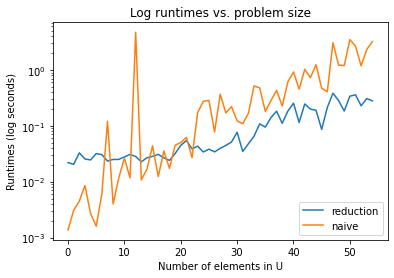

q4 results: All test cases passed!

In [33]:
grader.check("q4")

After running the q4 tests and looking at the generated graph, you should see that the naive solver is faster than the ILP reduction for small examples but the ILP reduction is faster for large examples. This highlights some of the tradeoffs between the two approaches: the ILP solver is more efficient for larger examples, but calling the solver incurs additional overhead, making it slower for small cases. On the flip side, the naive solver introduces relatively little additional overhead, but performs poorly on larger problems.

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit.

In [ ]:
grader.export(pdf=False, force_save=True, run_tests=True)